### Libraries

In [448]:
import cooler
import cooltools
import bioframe
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches
import venn

from dots_common import _2_step_loop_separation, make_loops_df, make_anchors_df

from coolpuppy import coolpup

import os


### Prep. Analysis Data (Call loops, prepare expected calculations etc)

In [449]:
nproc = 6
resolution = 10000
threshold = 1 #log2 threshold for loops strengths
samples = ['t0', 't12', 't30', 't60']
clrs_ = [cooler.Cooler(f"/home/carlos/oldies/manuscripts/notebooks/matrices/{sample_name}_q30.mcool::resolutions/{resolution}") for sample_name in samples]

In [450]:
hg38_chromsizes = bioframe.fetch_chromsizes("hg38")
hg38_cens = bioframe.fetch_centromeres("hg38")
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
hg38_arms = hg38_arms.set_index("chrom").loc[clrs_[0].chromnames].reset_index()

In [451]:
# check if files exist for expected calculations
if sum([os.path.exists(f"/home/carlos/oldies/manuscripts/review/expected/expected_{sample_name}.{resolution}.arms.tsv") for sample_name in samples]) == 4:
    expected_ = [pd.read_csv(f"/home/carlos/oldies/manuscripts/review/expected/expected_{sample_name}.{resolution}.arms.tsv", sep='\t') for sample_name in samples]
else:
    expected_ = [
        cooltools.expected_cis(
            clr,
            view_df=hg38_arms,
            nproc=nproc,
        )
        for clr in clrs_
    ]
    for i, expected_df in enumerate(expected_):
        expected_df.to_csv(f"/home/carlos/oldies/manuscripts/review/expected/expected_{samples[i]}.{resolution}.arms.tsv", index=False, sep='\t')

# check if files exist for loop calls
if sum([os.path.exists(f"/home/carlos/oldies/manuscripts/review/loop_calls/loops_{sample_name}.{resolution}.arms.tsv") for sample_name in samples]) == 4:
    dots_df_ = [pd.read_csv(f"/home/carlos/oldies/manuscripts/review/loop_calls/loops_{sample_name}.{resolution}.arms.tsv", sep='\t') for sample_name in samples]
else:
    dots_df_ = [
        cooltools.dots(
            clr,
            expected=expected,
            view_df=hg38_arms,
            max_loci_separation = 10_000_000,
            nproc=nproc,
            cluster_filtering=True,
        ) for clr, expected in zip(clrs_, expected_)
    ]

    for i, _df in enumerate(dots_df_):
        _df.to_csv(f"/home/carlos/oldies/manuscripts/review/loop_calls/loops_{samples[i]}.{resolution}.arms.tsv", index=False, sep='\t')

### LOOPS ~ Separation into COMMON, SPECIFIC loops

Loops are identified with cooltools dots methods.
Common loops are identified if a loop is identified in both samples, which show loop properties are satisfied.

We are going to implement 2 step procedure to identify "Specific" loops.
There are two objectives to satisfy for specific loops (Loop properties that satify kernels and loop strength):
1. A loop must be specific to a sample if loop properties are satisfied in only one of the samples.
2. Interaction coordinates from step 1, should only be enriched in signal intensity in the identified sample.

In [ ]:
loops, anchors = _2_step_loop_separation(
    dots_df_[0], dots_df_[1], 
    clrs_[0], clrs_[1],
    expected_[0], expected_[1],
    view_df=hg38_arms,
    merge_common = True, accepted_range=50_000, threshold = threshold, nproc=nproc)

In [ ]:
for k,v in loops.items():
    print(k, v.shape)
    df_out = v.copy()
    # reorder columns
    df_out['end1'] = df_out['start1'] + resolution
    df_out['end2'] = df_out['start2'] + resolution
    df_out = df_out[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']]
    df_out.iloc[:, :6].to_csv(f"unibind_data/loops_{k}.tsv", index=False, sep="\t")

for k,v in anchors.items():
    print(k, v.shape)
    df_out = v.copy()
    df_out['end'] = df_out['start'] + resolution
    df_out.to_csv(f"unibind_data/anchors_{k}.tsv", index=False, sep="\t")

In [17]:
df = make_loops_df(loops)
t0_t12_df = df.copy()
t0_t12_anchors_df = make_anchors_df(anchors)

In [ ]:
for loop_type in df['type'].unique():
    current_df = df[df['type'] == loop_type]

    print(loop_type)
    print(current_df['length'].median(), current_df['length'].mean())

print(f"All loops\n{df['length'].median()} {df['length'].mean()}")

### LOOPS ~ APA

In [19]:
apa_flank = 100_000

In [ ]:

pups_ = [
	coolpup.pileup(clr, df, features_format='bedpe', view_df=hg38_arms, expected_df=expected,
							groupby=['type'], flank=apa_flank, nproc=nproc, local=False)
							for clr, expected in zip(clrs_[:2], expected_)
]

In [21]:
def min_max_comp(data__):
	vmin = []
	vmax = []
	for data_ in data__:
		data_ = data_.data
		for data in data_:
			vmin.append(np.nanmin(data))
			vmax.append(np.nanmax(data))
	vmax = np.nanmax(vmax)
	vmin = np.nanmin(vmin)

	vmax = 2 ** (np.max(np.abs(np.log2([vmin, vmax]))))

	if vmax >= 1:
		vmin = 2 ** -np.log2(vmax)
	return vmin, vmax

In [22]:
def get_corner_scores(data, n_bins):
    center_idx = data.shape[0] // 2
    center_score = data[center_idx, center_idx]
    tl = np.nanmean(data[:n_bins, :n_bins]) 
    br = np.nanmean(data[-n_bins:, -n_bins:])
    tr = np.nanmean(data[:n_bins, -n_bins:])
    bl = np.nanmean(data[-n_bins:, :n_bins])

    return [
        center_score / tl, 
        center_score / tr, 
        center_score / bl, 
        center_score / br]

def central_score(data, n):
    c = data.shape[0] // 2
    return np.nanmean(data[c - n // 2 : c + n // 2 + 1, c - n // 2 : c + n // 2 + 1])

In [23]:
corner_size = 6
central_size = 1

In [24]:
for pup in pups_:
    pup['central_score'] = pup.apply(
                    lambda x: central_score(x['data'], central_size), axis=1
                )

for pup in pups_:
    pup['corner_scores'] = pup.apply(
                    lambda x: get_corner_scores(x['data'], corner_size), axis=1
                )

In [25]:
pups_reordered = []
#re_order = ["common_loops1", "common_loops2", "specific_loops1", "specific_loops2", "all"] # order if common loops are not merged
re_order = ["common_loops", "specific_loops1", "specific_loops2", "all"]

for pup in pups_:
    pup_df = pup.copy()

    pup_df.set_index("type", inplace=True)
    pup_df = pup_df.reindex(re_order)
    pup_df["type"] = pup_df.index
    pup_df.reset_index(drop=True, inplace=True)
    pups_reordered.append(pup_df)

In [ ]:
import importlib
import dots_common
importlib.reload(dots_common)

In [27]:
from matplotlib.colors import LinearSegmentedColormap
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["white", "white", "#C42021"], N=256)
height =6
sample_names = ["Control", "12min"]


In [ ]:
from dots_common import add_scores
for scores_type in ["corner_scores", "central_score"]:

      vmin, vmax = min_max_comp(pups_reordered)

      norm = LogNorm(vmin=vmin, vmax=vmax)
      fig, axs = plt.subplots(
            ncols=4,
            nrows=len(pups_reordered),
            figsize=(24, height*2),
            sharex=True,
            sharey=True,
      )

      font_scale = 2

      types_dict = {
            "specific_loops1": "Control Specific", 
            "specific_loops2": "12Min Specific", 
            "common_loops": "Common",  
            "all": "All Loops"}

      for i, pup in enumerate(pups_reordered):
            print(pup.clr)
            types =  pup.type

            for idx, ax in enumerate(axs[i, :]):
                  s = sns.heatmap(
                        pup.iloc[idx].data,
                        cmap=cmp,
                        norm=norm,
                        ax=ax,
                        cbar=False,
                        xticklabels=False,
                        yticklabels=False,
                  )
                  current_type = types[idx]
                  if i == 0:
                        s.set_title(types_dict[current_type], fontsize=2.5 * (4.94 + height))
                  if idx == 0:
                        s.set_ylabel(sample_names[i], fontsize=2.5 * (4.94 + height))
                  else:
                        s.set_ylabel("")
                  mtx_size = pup.iloc[idx].data.shape[0]
                        
                  score_central = pup.central_score[idx]
                  score_corner = pup.corner_scores[idx]
                  if scores_type == "corner_scores":
                        dots_common.add_scores(scores_type, score_corner, ax, mtx_size, corner_size, font_scale = 2, height = 6)
                  elif scores_type == "central_score":
                        dots_common.add_scores(scores_type, score_central, ax, mtx_size, central_size, font_scale = 2, height = 6)

      fig.set_tight_layout(True)
      fig.savefig(f"/home/carlos/oldies/manuscripts/review/reworked_figs/fig4e_{scores_type}.svg")
      fig.savefig(f"/home/carlos/oldies/manuscripts/review/reworked_figs/fig4e_{scores_type}.png", dpi = 300)
      #fig.clf()

### LOOPS ~ VENN

In [29]:
def prepare_merged_anchor(dots_df_, min_dist=50_000):
    loops_df_list = [df.iloc[:, :6] for df in dots_df_]
    all_dots = pd.concat(loops_df_list).drop_duplicates()
    anchors1 = all_dots.iloc[:, :3]
    anchors2 = all_dots.iloc[:, 3:6]
    anchors1.columns = ["chrom", "start", "end"]
    anchors2.columns = ["chrom", "start", "end"]
    all_anchors = pd.concat([anchors1, anchors2]).drop_duplicates().reset_index(drop=True)
    all_anchors = bioframe.merge(all_anchors, min_dist=min_dist)
    return all_anchors, loops_df_list

def overlap_to_all_anchors(loops_df_list, all_anchors):
    for i, df in enumerate(loops_df_list):
        anchors1 = df.iloc[:, :3]
        anchors2 = df.iloc[:, 3:6]
        anchors1.columns = ["chrom", "start", "end"]
        anchors2.columns = ["chrom", "start", "end"]

        overlap1 = bioframe.overlap(anchors1, all_anchors, return_index=True)
        overlap2 = bioframe.overlap(anchors2, all_anchors, return_index=True)

        loops_df_list[i].loc[:, "anchor1"] = overlap1.loc[:, "index_"]
        loops_df_list[i].loc[:, "anchor2"] = overlap2.loc[:, "index_"]

        loops_df_list[i].sort_values(["anchor1", "anchor2"], inplace=True)
        loops_df_list[i].drop_duplicates(subset=["anchor1", "anchor2"], inplace=True)

    return loops_df_list

min_dist = 50_000

anchors_all, loops_all = prepare_merged_anchor(dots_df_= dots_df_, min_dist = min_dist)
loops_all = overlap_to_all_anchors(loops_all, anchors_all)

In [ ]:
import venn
cmap = ["#465775", "#A63446", "#F5B841", "#9DBBAE"]
alpha = 0.60

# LOOPS
venn_df_all = {}

for dots_df, s in zip(loops_all, samples):

    rows_as_tuples = [f"{row[6]}-{row[7]}" for index, row in dots_df.iterrows()]
    venn_df_all[s] = set(rows_as_tuples)

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 20),
    gridspec_kw={"hspace": 0.1},
)
v = venn.venn(
    venn_df_all,
    fontsize=18,
    fmt="{percentage:.1f}%",
    cmap=cmap,
    legend_loc=None,
    ax=ax[0],
    alpha=alpha,
)


# draw venn diagram for anchors

anchors_dfs_dict = {}
for dots_df, s in zip(loops_all, samples):
    anchors_dfs_dict[s] = set()
    for i, entry in dots_df.iterrows():
        anchors_dfs_dict[s].add(entry[6])
        anchors_dfs_dict[s].add(entry[7])

venn.venn(
    anchors_dfs_dict,
    fontsize=18,
    fmt="{percentage:.1f}%",
    cmap=cmap,
    legend_loc=None,
	ax=ax[1],
    alpha=alpha,
)

plt.tight_layout()
plt.savefig("/home/carlos/oldies/manuscripts/review/reworked_figs/loops_anchors_venn.svg")

In [8]:
def venn_diagram_data(list1, list2, list3, list4):
    intersection_1_2_3_4 = set(list1) & set(list2) & set(list3) & set(list4)
    intersection_1_2 = set(list1) & set(list2)
    intersection_1_3 = set(list1) & set(list3)
    intersection_1_4 = set(list1) & set(list4)
    intersection_2_3 = set(list2) & set(list3)
    intersection_2_4 = set(list2) & set(list4)
    intersection_3_4 = set(list3) & set(list4)
    intersection_1_2_3 = set(list1) & set(list2) & set(list3)
    intersection_1_2_4 = set(list1) & set(list2) & set(list4)
    intersection_1_3_4 = set(list1) & set(list3) & set(list4)
    intersection_2_3_4 = set(list2) & set(list3) & set(list4)
    unique_1 = set(list1) - set(list2) - set(list3) - set(list4)
    unique_2 = set(list2) - set(list1) - set(list3) - set(list4)
    unique_3 = set(list3) - set(list1) - set(list2) - set(list4)
    unique_4 = set(list4) - set(list1) - set(list2) - set(list3)

    venn_data = {
        "1,2,3,4 intersection": list(intersection_1_2_3_4),
        "1,2 intersection": list(intersection_1_2),
        "1,3 intersection": list(intersection_1_3),
        "1,4 intersection": list(intersection_1_4),
        "2,3 intersection": list(intersection_2_3),
        "2,4 intersection": list(intersection_2_4),
        "3,4 intersection": list(intersection_3_4),
        "1,2,3 intersection": list(intersection_1_2_3),
        "1,2,4 intersection": list(intersection_1_2_4),
        "1,3,4 intersection": list(intersection_1_3_4),
        "2,3,4 intersection": list(intersection_2_3_4),
        "1 unique": list(unique_1),
        "2 unique": list(unique_2),
        "3 unique": list(unique_3),
        "4 unique": list(unique_4),
    }
    return venn_data

venn_data = venn_diagram_data(venn_df_all['t0'], venn_df_all['t12'], venn_df_all['t30'], venn_df_all['t60'])

In [9]:
df_to_save = {
    'chrom1': [],
    'start1': [],
    'end1': [],
    'chrom2': [],
    'start2': [],
    'end2': [],
    'type': []
}
for k,v in venn_data.items():
    for tup in v:
        val1, val2 = tup.split("-")
        val1, val2 = int(val1), int(val2)
        anchor1 = anchors_all.iloc[val1]
        anchor2 = anchors_all.iloc[val2]
        df_to_save['chrom1'].append(anchor1['chrom'])
        df_to_save['start1'].append(anchor1['start'])
        df_to_save['end1'].append(anchor1['end'])
        df_to_save['chrom2'].append(anchor2['chrom'])
        df_to_save['start2'].append(anchor2['start'])
        df_to_save['end2'].append(anchor2['end'])
        df_to_save['type'].append(k)

df_to_save = pd.DataFrame(df_to_save)
df_to_save.to_csv("unibind_data/loops_venn.tsv", sep="\t", index=False)

### Loops ~ Transition

In [ ]:
transition_data = {}

for i, i_sample in enumerate(samples[:-1]):
    for j, j_sample in enumerate(samples[1:]):
        if j != i:
            continue
        idx_sample_i = samples.index(i_sample)
        idx_sample_j = samples.index(j_sample)
        dots_df_i = dots_df_[idx_sample_i].copy()
        dots_df_j = dots_df_[idx_sample_j].copy()
        loops, anchors = _2_step_loop_separation(
            dots_df_i, dots_df_j, 
            clrs_[idx_sample_i], clrs_[idx_sample_j],
            expected_[idx_sample_i], expected_[idx_sample_j],
            view_df=hg38_arms, 
            merge_common = True, accepted_range=50_000, threshold = threshold)
        transition_data[f"{i_sample}_{j_sample}"] = (loops, anchors)
        for k,v in anchors.items():
            v.to_csv(f"/home/carlos/oldies/manuscripts/review/spec_anchors/anchors_{k}_{i_sample}_{j_sample}.tsv", index=False, sep="\t")
        for k,v in loops.items():
            v.to_csv(f"/home/carlos/oldies/manuscripts/review/spec_loops/loops_{k}_{i_sample}_{j_sample}.tsv", index=False, sep="\t")
fig, axs = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(10, 10),
    sharey="row",
    gridspec_kw={"wspace": 0.1}
)

# plot loops
for i, i_sample in enumerate(samples[:-1]):
    for j, j_sample in enumerate(samples[1:]):
        if j != i:
            continue
        
        labels = (i_sample, j_sample)
        weights_loops = {
        "Common": (
            transition_data[f"{i_sample}_{j_sample}"][0]["common_loops"].shape[0],

        ),
        "Unique": (
            transition_data[f"{i_sample}_{j_sample}"][0]["specific_loops1"].shape[0],
            transition_data[f"{i_sample}_{j_sample}"][0]["specific_loops2"].shape[0],
        ),
        }

        df = pd.DataFrame(weights_loops, index=labels)
        
        ax=axs[0, i]
        df.plot.bar(ax=ax, stacked=True, rot=0, color=["#465775", "#A63446"], width=0.8, legend=False)
        ax.set_xticklabels(labels=labels, fontsize=14)
        ax.tick_params(axis='y', labelsize=14)

        weights_anchors = {
        "Below": (
            transition_data[f"{i_sample}_{j_sample}"][1]["common_anchors"].shape[0],

        ),
        "Above": (
            transition_data[f"{i_sample}_{j_sample}"][1]["specific_anchors1"].shape[0],
            transition_data[f"{i_sample}_{j_sample}"][1]["specific_anchors2"].shape[0],
        ),
        }

        df = pd.DataFrame(weights_anchors, index=labels)
        ax=axs[1, i]
        df.plot.bar(ax=ax, stacked=True, rot=0, color=["#465775", "#A63446"], width=0.8, legend=False)
        ax.set_xticklabels(labels=labels, fontsize=14)

fig.savefig("/home/carlos/oldies/manuscripts/review/reworked_figs/fig_transition.svg", bbox_inches='tight')
fig.savefig("/home/carlos/oldies/manuscripts/review/reworked_figs/fig_transition.png", dpi=300, bbox_inches='tight')

### LOOPS ~ REPAIR 

In [33]:
import data_handlers
import bbi

In [34]:
loop_types = ["common_loops", "specific_loops1", "specific_loops2"]

flank_size = 100_000
nbins_main = 320
nbins_flank = 100

from scipy.ndimage import gaussian_filter1d

plot_dfs = []

for i, loop_type in enumerate(loop_types):
    df_now = t0_t12_df.loc[t0_t12_df['type'] == loop_type].copy()

    for j, data_name in enumerate(['xr-cpd-over-sim', 'xr-64-over-sim', 'ctcf', 'dnase', 'faire']):
        
        if data_name in ['xr-cpd-over-sim', 'xr-64-over-sim']:
        
            start_data = bbi.stackup(data_handlers.BWS[data_name], df_now.chrom1, df_now.start1 - flank_size, df_now.start1, nbins_flank) / data_handlers.MEANS_BW[data_name]
            end_data = bbi.stackup(data_handlers.BWS[data_name], df_now.chrom2, df_now.start2 + resolution, df_now.start2 + resolution + flank_size, nbins_flank) / data_handlers.MEANS_BW[data_name]
            main_data = bbi.stackup(data_handlers.BWS[data_name], df_now.chrom1, df_now.start1, df_now.start2 + resolution, nbins_main) / data_handlers.MEANS_BW[data_name]

            stack = np.hstack([start_data, main_data, end_data])
            
            stack = np.nanmean(stack, axis=0)
            stack = gaussian_filter1d(stack, 2)
            
            plot_df = pd.DataFrame(stack).melt()
            plot_df['variable'] = np.arange(plot_df.shape[0])
            plot_df['type'] = loop_type
            plot_df['data_name'] = data_name
            plot_dfs.append(plot_df)
        
        else:
            anchors1 = df_now.iloc[:, :3]
            anchors1['loop_idx'] = df_now.index
            anchors2 = df_now.iloc[:, 3:6]
            anchors2['loop_idx'] = df_now.index
            anchors1.columns = ["chrom", "start", "end", "loop_idx"]
            anchors2.columns = ["chrom", "start", "end", "loop_idx"]
            all_anchors = pd.concat([anchors1, anchors2]).reset_index(drop=True)
            
            main_data = bbi.stackup(data_handlers.BWS[data_name], all_anchors.chrom, all_anchors.start, all_anchors.end, 1) / data_handlers.MEANS_BW[data_name]

            plot_df = pd.DataFrame(main_data).melt()
            plot_df['variable'] = np.arange(plot_df.shape[0])
            plot_df['type'] = loop_type
            plot_df['data_name'] = data_name
            plot_df['loop_idx'] = all_anchors['loop_idx']

            left_anchors_values = plot_df.iloc[:len(anchors1), 1].to_numpy()
            right_anchors_values = plot_df.iloc[len(anchors1):, 1].to_numpy()
            mean_vals = (left_anchors_values + right_anchors_values) / 2
            plot_df = plot_df.iloc[:len(anchors1)].copy()
            plot_df['value'] = mean_vals
            plot_dfs.append(plot_df)

plot_df_loops = pd.concat(plot_dfs).reset_index(drop=True)

In [ ]:
grid_specs = {
    'width_ratios': [1, .5],
    'height_ratios': [1, 1],
# set spacing
    'hspace': 0.1, 'wspace': 0.1
}

fig, axs = plt.subplots(2,2, figsize=(20, 10), sharex='col', gridspec_kw=grid_specs)

s_colors = ['#465775', '#A63446', '#F5B841']


data_name_mapping_loops = {
    'xr-cpd-over-sim' : 'CPD',
    'xr-64-over-sim' : '6-4(PP)'
}

loop_categories = ['specific_loops1', 'common_loops', 'specific_loops2']

for i, data_name in enumerate(data_name_mapping_loops):
    ax = axs[i,0]
    df_now = plot_df_loops.loc[plot_df_loops['data_name'] == data_name].copy()

    # set plot order for loop types
    df_now.type = pd.Categorical(df_now.type, categories=loop_categories, ordered=True)

    sns.lineplot(data=df_now, x='variable', y='value', hue='type', palette=s_colors, ax=ax)

    # set legend to middle
    if i == 0:
        ax.legend(['Control Specific', 'Common',  '12 min Specific'], loc='center', bbox_to_anchor=(0.5, 0.8), ncol=1, fontsize=15)
    else:
        ax.get_legend().remove()
    ax.set_title(f'{data_name_mapping_loops[data_name]}', fontsize=15)
    ax.set_ylabel('Normalized Repair Levels', fontsize=15)
    ax.set_xlabel('')

    ax.set_xticks([nbins_flank, nbins_flank + nbins_main])
    ax.set_xticklabels(["5' Anchor", "3' Anchor"], fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

data_name_mapping_anchors = {
    'dnase' : 'Pre-UV DNase-Seq Levels',
    'faire' : 'Pre-UV Faire-Seq Levels'
}
anchor_categories = ['specific_loops1', 'common_loops',  'specific_loops2']
for i, data_name in enumerate(data_name_mapping_anchors):
    ax = axs[i,1]
    df_now = plot_df_loops.loc[plot_df_loops['data_name'] == data_name].copy()
    #df_now.type = pd.Categorical(df_now.type, categories=anchor_categories, ordered=True)
    sns.boxplot(data=df_now, x='type', y='value', palette=s_colors, ax=ax, showfliers=True)

    pairs = [
    ('specific_loops1', 'specific_loops2'),
    ('specific_loops1', 'common_loops'),
    ('specific_loops2', 'common_loops')
    ]
    
    from statannotations.Annotator import Annotator

    annotator = Annotator(ax, pairs, data=df_now, x='type', y='value')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    annotator.apply_and_annotate()

    ax.set_title(f'{data_name_mapping_anchors[data_name]}', fontsize=15)
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.set_xticklabels(['Control Specific', 'Common',  '12 min Specific'], fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

plt.tight_layout()
fig.savefig("/home/carlos/oldies/manuscripts/review/reworked_figs/fig4f.svg", bbox_inches='tight')
fig.savefig("/home/carlos/oldies/manuscripts/review/reworked_figs/fig4f.png", dpi=300, bbox_inches='tight')

### Common Loops

In [192]:
common_loops = loops['common_loops'].copy()
common_loops['end1'], common_loops['end2'] = common_loops['start1'] + resolution, common_loops['start2'] + resolution
common_loops = common_loops[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']]
common_loops['loop_strength'] = cooltools.pileup(clr = clrs_[1], features_df=common_loops, view_df=hg38_arms, expected_df= expected_[1], flank=0, nproc=nproc).flatten()
common_loops['loop_strength_q'] = pd.qcut(common_loops['loop_strength'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [ ]:
pups_common_ = [
	coolpup.pileup(clr, common_loops, features_format='bedpe', view_df=hg38_arms, expected_df=expected,
							groupby=['loop_strength_q'], flank=apa_flank, nproc=nproc, local=False)
							for clr, expected in zip(clrs_[:2], expected_)
]

In [194]:
for pup in pups_common_:
    pup['central_score'] = pup.apply(
                    lambda x: central_score(x['data'], central_size), axis=1
                )

for pup in pups_common_:
    pup['corner_scores'] = pup.apply(
                    lambda x: get_corner_scores(x['data'], corner_size), axis=1
                )
    
vmin, vmax = min_max_comp(pups_common_)
norm = LogNorm(vmin=vmin, vmax=vmax)

In [195]:
pups_common_reordered = []
re_order = ['Q1', 'Q2', 'Q3', 'Q4', 'all']

for pup in pups_common_:
    pup_df = pup.copy()

    pup_df.set_index("loop_strength_q", inplace=True)
    pup_df = pup_df.reindex(re_order)
    pup_df["loop_strength_q"] = pup_df.index
    pup_df.reset_index(drop=True, inplace=True)
    pups_common_reordered.append(pup_df)

In [ ]:
grid_specs = {
    'hspace': 0.01, 'wspace': 0.01
}
fig, axs = plt.subplots(2, 4, figsize=(24, 12))
scores_type = "central_score"

for i, pup in enumerate(pups_common_reordered):
    for idx, ax in enumerate(axs[i, :]):
        s = sns.heatmap(
            pup.iloc[idx].data,
            cmap=cmp,
            norm=norm,
            ax=ax,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
        )
        current_type = pup.iloc[idx].loop_strength_q
        if i == 0:
            s.set_title(current_type, fontsize=2.5 * (4.94 + height))
        if idx == 0:
            s.set_ylabel(sample_names[i], fontsize=2.5 * (4.94 + height))
        mtx_size = pup.iloc[idx].data.shape[0]

        score_central = pup.central_score[idx]
        score_corner = pup.corner_scores[idx]
        if scores_type == "corner_scores":
            dots_common.add_scores(scores_type, score_corner, ax, mtx_size, corner_size, font_scale = 2, height = 6)
        elif scores_type == "central_score":
            dots_common.add_scores(scores_type, score_central, ax, mtx_size, central_size, font_scale = 2, height = 6)

fig.savefig(f"/home/carlos/oldies/manuscripts/review/reworked_figs/supp_common_{scores_type}.svg", bbox_inches='tight')
fig.savefig(f"/home/carlos/oldies/manuscripts/review/reworked_figs/supp_common_{scores_type}.png", dpi=300, bbox_inches='tight')

In [197]:
plot_dfs_rep = []

for i, quant in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    df_now = common_loops.loc[common_loops['loop_strength_q'] == quant].copy()
    for j, data_name in enumerate(['xr-cpd-over-sim', 'xr-64-over-sim', 'dnase', 'ctcf', 'faire']):
        start_data = bbi.stackup(data_handlers.BWS[data_name], df_now.chrom1, df_now.start1 - flank_size, df_now.start1, nbins_flank) / data_handlers.MEANS_BW[data_name]
        end_data = bbi.stackup(data_handlers.BWS[data_name], df_now.chrom2, df_now.start2 + resolution, df_now.start2 + resolution + flank_size, nbins_flank) / data_handlers.MEANS_BW[data_name]
        main_data = bbi.stackup(data_handlers.BWS[data_name], df_now.chrom1, df_now.start1, df_now.start2 + resolution, nbins_main) / data_handlers.MEANS_BW[data_name]

        stack = np.hstack([start_data, main_data, end_data])

        stack = np.nanmean(stack, axis=0)
        stack = gaussian_filter1d(stack, 2)
        
        plot_df = pd.DataFrame(stack).melt()
        plot_df['variable'] = np.arange(plot_df.shape[0])
        plot_df['type'] = quant
        plot_df['data_name'] = data_name
        plot_dfs_rep.append(plot_df)

plot_dfs_rep = pd.concat(plot_dfs_rep).reset_index(drop=True)

In [198]:
plot_df_common_anchors = []

for i, quant in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    df_now = common_loops.loc[common_loops['loop_strength_q'] == quant].copy().reset_index(drop=True)
    anchors1 = df_now.iloc[:, :3]
    anchors1['loop_idx'] = df_now.index
    anchors2 = df_now.iloc[:, 3:6]
    anchors2['loop_idx'] = df_now.index
    anchors1.columns = ["chrom", "start", "end", "loop_idx"]
    anchors2.columns = ["chrom", "start", "end", "loop_idx"]
    all_anchors = pd.concat([anchors1, anchors2]).reset_index(drop=True)
    for j, data_name in enumerate(['dnase', 'ctcf', 'faire']):
        main_data = bbi.stackup(data_handlers.BWS[data_name], all_anchors.chrom, all_anchors.start, all_anchors.end, 1) 
        main_data = main_data / data_handlers.MEANS_BW[data_name] #if data_name == 'dnase' else main_data
        plot_df = pd.DataFrame(main_data).melt()
        plot_df['variable'] = np.arange(plot_df.shape[0])
        plot_df['data_name'] = data_name
        plot_df['loop_idx'] = all_anchors['loop_idx']
        plot_df['q'] = quant

        left_anchors_values = plot_df.iloc[:len(anchors1), 1].to_numpy()
        right_anchors_values = plot_df.iloc[len(anchors1):, 1].to_numpy()
        mean_vals = (left_anchors_values + right_anchors_values) / 2
        plot_df = plot_df.iloc[:len(anchors1)].copy()
        plot_df['value'] = mean_vals
        plot_df_common_anchors.append(plot_df)

plot_df_common_anchors = pd.concat(plot_df_common_anchors).reset_index(drop=True)

In [ ]:
grid_specs = {
    'width_ratios': [1, .5],
    'height_ratios': [1, 1],
# set spacing
    'hspace': 0.1, 'wspace': 0.1
}

fig, axs = plt.subplots(2,2, figsize=(20, 10), sharex='col', gridspec_kw=grid_specs)

s_colors = ['#465775', '#A63446', '#F5B841', '#9DBBAE']

data_name_mapping_loops = {
    'xr-cpd-over-sim' : 'CPD',
    'xr-64-over-sim' : '6-4(PP)'
}

for i, data_name in enumerate(data_name_mapping_loops):
    ax = axs[i,0]
    df_now = plot_dfs_rep.loc[plot_dfs_rep['data_name'] == data_name].copy()
    sns.lineplot(data=df_now, x='variable', y='value', hue='type', ax=ax, palette=s_colors)

    ax.set_title(f'{data_name_mapping_loops[data_name]}', fontsize=15)
    ax.set_ylabel('Normalized Repair Levels', fontsize=15)
    ax.set_xlabel('')

    ax.set_xticks([nbins_flank, nbins_flank + nbins_main])
    ax.set_xticklabels(["5' Anchor", "3' Anchor"], fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

data_name_mapping_anchors = {
    'dnase' : 'Pre-UV DNase-Seq Levels',
    'faire' : 'Pre-UV Faire-Seq Levels'
}

for i, data_name in enumerate(data_name_mapping_anchors):
    ax = axs[i,1]
    df_now = plot_df_common_anchors.loc[plot_df_common_anchors['data_name'] == data_name].copy()

    sns.boxplot(data=df_now, x='q', y='value', ax=ax, showfliers=True, palette=s_colors)

    pairs = [('Q1', 'Q2'), ('Q1', 'Q3'), ('Q1', 'Q4'), ('Q2', 'Q3'), ('Q2', 'Q4'), ('Q3', 'Q4')]
    
    from statannotations.Annotator import Annotator

    annotator = Annotator(ax, pairs, data=df_now, x='q', y='value')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    annotator.apply_and_annotate()

    ax.set_title(f'{data_name_mapping_anchors[data_name]}', fontsize=15)
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

plt.tight_layout()

fig.savefig("/home/carlos/oldies/manuscripts/review/reworked_figs/supp_rep.svg", bbox_inches='tight')
fig.savefig("/home/carlos/oldies/manuscripts/review/reworked_figs/supp_rep.png", dpi=300, bbox_inches='tight')

### Overlaps

In [ ]:
samples_df = {k: [] for k in samples}
import itertools
for i, (c1, c2) in enumerate(list(itertools.permutations(samples, 2))):
    print(c1, c2)
    idx_sample_i = samples.index(c1)
    idx_sample_j = samples.index(c2)
    dots_df_i = dots_df_[idx_sample_i].copy()
    dots_df_j = dots_df_[idx_sample_j].copy()
    
    loops, anchors = _2_step_loop_separation(
        dots_df_i, dots_df_j, 
        clrs_[idx_sample_i], clrs_[idx_sample_j],
        expected_[idx_sample_i], expected_[idx_sample_j],
        view_df=hg38_arms, 
        merge_common = True, accepted_range=50_000, threshold = threshold)
    loops_common = loops['common_loops']
    loops_common['end1'] = loops_common['start1'] + resolution
    loops_common['end2'] = loops_common['start2'] + resolution

    loops_specific1 = loops['specific_loops1']
    loops_specific1['end1'] = loops_specific1['start1'] + resolution
    loops_specific1['end2'] = loops_specific1['start2'] + resolution

    loops_common['type'] = 'common_loops'
    loops_specific1['type'] = 'specific_loops1'
    samples_df[c1].append(pd.concat([loops_common.iloc[:, [0,1,2,3,4,5,-1]], loops_specific1.iloc[:, [0,1,2,3,4,5,-1]]]))

In [259]:
dots_df_now = []

for k,v in samples_df.items():
    dots_df_now.append(pd.concat(v).copy().iloc[:, :6].drop_duplicates()[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2',]])

In [268]:
import itertools

all_loops_per_sample = []
#for i, df in enumerate(dots_df_):
for i, df in enumerate(dots_df_now):
    loops_now = df.iloc[:, :6].copy()
    all_loops_per_sample.append(loops_now)

flank = 25_000
all_sample_ranges = []
for i, loop_df in enumerate(all_loops_per_sample):
    per_sample_ranges = {chrom: [] for chrom in clrs_[0].chromnames}
    for idx, row in loop_df.iterrows():
        r1 = range(row['start1'] - flank, row['end1'] + flank)
        r2 = range(row['start2'] - flank, row['end2'] + flank)
        per_sample_ranges[row['chrom1']].append((r1,r2, idx))
    all_sample_ranges.append(per_sample_ranges)

In [ ]:
all_loops_found = [[[] for i in range(len(dots_df_[k]))] for k in range(4)]

import tqdm
for i, (c1, c2) in enumerate(itertools.combinations(range(4), 2)):
    print(c1,c2)
    current_ranges = all_sample_ranges[c1]
    for idx, row in tqdm.tqdm(all_loops_per_sample[c2].iterrows(), total=all_loops_per_sample[c2].shape[0]):
        midpoint1 = (row['start1'] + row['end1']) // 2
        midpoint2 = (row['start2'] + row['end2']) // 2
        chrom_now = row['chrom1']
        c2_idx = idx
        for r_now in current_ranges[chrom_now]:
            c1_idx = r_now[2]
            if midpoint1 in r_now[0] and midpoint2 in r_now[1]:
                all_loops_found[c1][c1_idx].append(c2)


for i, n in enumerate(all_loops_found):
    for j, m in enumerate(n):
        all_loops_found[i][j] = list(set(m))

In [425]:
deseq_lrt = pd.read_csv("/home/carlos/oldies/manuscripts/notebooks/RNA/all_deseq_lrt.tsv", sep="\t")
deseq_lrt.rename(columns={'gene_id': 'ensembl_gene_id'}, inplace=True)
deseq_lrt['chromosome_name'] = [f"chr{chrom}" for chrom in deseq_lrt['chromosome_name']]
deseq_lrt = deseq_lrt[['chromosome_name', 'start_position', 'end_position', 'external_gene_name', 'padj']]
deseq_lrt.rename(columns={'chromosome_name': 'chrom', 'start_position': 'start', 'end_position': 'end', 'external_gene_name': 'gene_name'}, inplace=True)
deseq_lrt.start = deseq_lrt.start.astype(int)
deseq_lrt.end = deseq_lrt.end.astype(int)

deseq_lrt.sort_values('padj', inplace=True)
deseq_lrt.dropna(subset=['gene_name'], inplace=True)

In [436]:
anchor_flank = 25_000
all_anchors_per_sample = []
for i, df in enumerate(dots_df_):
    loops_now = df.iloc[:, :6].copy()
    loops_now['loop_presence'] = all_loops_found[i]
    left_anchors = loops_now.iloc[:, [0,1,2,-1]].copy()
    right_anchors = loops_now.iloc[:, [3,4,5,-1]].copy()
    left_anchors.columns = ['chrom', 'start', 'end', 'loop_presence']
    right_anchors.columns = ['chrom', 'start', 'end', 'loop_presence']
    left_anchors['loop_idx'] = left_anchors.index
    right_anchors['loop_idx'] = right_anchors.index
    left_anchors['start'] = left_anchors['start'] - anchor_flank
    left_anchors['end'] = left_anchors['end'] + anchor_flank
    right_anchors['start'] = right_anchors['start'] - anchor_flank
    right_anchors['end'] = right_anchors['end'] + anchor_flank
    
    all_anchors = pd.concat([left_anchors, right_anchors]).reset_index(drop=True)
    all_anchors_per_sample.append(all_anchors)

goi_data = {}
top_N = 25
for goi in deseq_lrt.gene_name.unique():
    goi_arr = []
    for i, df in enumerate(all_anchors_per_sample):
        overlap = bioframe.overlap(df, deseq_lrt, return_index=True).dropna(subset=['chrom_'])
        all_l = []
        for l in overlap.loc[overlap['gene_name_'] == goi].loop_presence.to_list():
            
            if len(l) == 3: # present in all samples
                continue
            if len(l) == 0:
                continue
            if len(l) > 0:
                new_l = l + [i]
                all_l.append(new_l)
        all_l = [list(t) for t in set(tuple(lst) for lst in all_l)]
        for l_now in all_l:
            goi_arr.append(sorted(l_now))

    mtx = np.zeros((len(goi_arr), 4))
    for i, l_now in enumerate(goi_arr):
        for s in l_now:
            mtx[i,s] = 1
    
    if np.sum(mtx) != 0:
        goi_data[goi] = mtx
    if len(goi_data) == top_N:
        break

In [437]:
goi_data = {k: v for k,v in goi_data.items() if v.shape[0] > 0}

In [438]:
topGenes = list(goi_data.keys())

/tmp/ipykernel_4370/4278228950.py:55: RuntimeWarning: divide by zero encountered in log10
  minus_log10_padj = -np.log10(padj)
/tmp/ipykernel_4370/4278228950.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  b1.set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=20)
/tmp/ipykernel_4370/4278228950.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  b2.set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=20)
/tmp/ipykernel_4370/4278228950.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


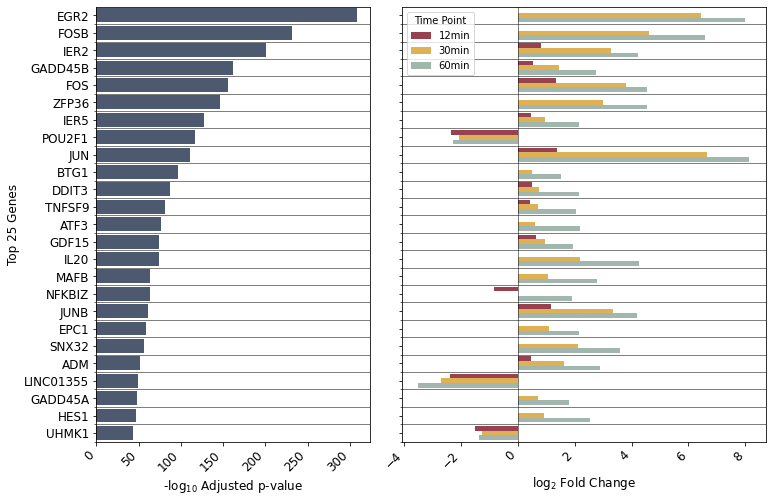

In [443]:
fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=1, sharey="row",
 gridspec_kw={"wspace": 0.1, 'width_ratios': [3, 4]})

degs_0_12 = pd.read_csv("/home/carlos/oldies/manuscripts/notebooks/RNA/t0-t12.degs.tsv", sep="\t")
degs_0_60 = pd.read_csv("/home/carlos/oldies/manuscripts/notebooks/RNA/t0-t60.degs.tsv", sep="\t")
degs_0_30 = pd.read_csv("/home/carlos/oldies/manuscripts/notebooks/RNA/t0-t30.degs.tsv", sep="\t")

topN_now = 25
deseq_lrt = pd.read_csv("/home/carlos/oldies/manuscripts/notebooks/RNA/all_deseq_lrt.tsv", sep="\t")
deseq_lrt.rename(columns={'gene_id': 'ensembl_gene_id'}, inplace=True)
deseq_lrt_intersect_topN = deseq_lrt.loc[deseq_lrt.external_gene_name.isin(topGenes)].sort_values(by='padj').head(topN_now)

plot_dict_FC = {
    "geneName": [],
    "Fold Change": [],
    "Time Point": []
}

fc_12 = degs_0_12.loc[degs_0_12.ensembl_gene_id.isin(deseq_lrt_intersect_topN.ensembl_gene_id.values)]
fc_30 = degs_0_30.loc[degs_0_30.ensembl_gene_id.isin(deseq_lrt_intersect_topN.ensembl_gene_id.values)]
fc_60 = degs_0_60.loc[degs_0_60.ensembl_gene_id.isin(deseq_lrt_intersect_topN.ensembl_gene_id.values)]

plot_dict_padj = {
    "geneName": [],
    "padj": [],
}

for gene in deseq_lrt_intersect_topN.external_gene_name.values:
    
    plot_dict_FC["geneName"].append(gene)
    plot_dict_FC["geneName"].append(gene)
    plot_dict_FC["geneName"].append(gene)


    if gene not in fc_12.external_gene_name.values:
        plot_dict_FC["Fold Change"].append(0)
    else:
        plot_dict_FC["Fold Change"].append(fc_12.loc[fc_12.external_gene_name == gene].log2FoldChange.values[0])
    plot_dict_FC["Time Point"].append("12min")

    if gene not in fc_30.external_gene_name.values:
        plot_dict_FC["Fold Change"].append(0)
    else:
        plot_dict_FC["Fold Change"].append(fc_30.loc[fc_30.external_gene_name == gene].log2FoldChange.values[0])
    plot_dict_FC["Time Point"].append("30min")

    if gene not in fc_60.external_gene_name.values:
        plot_dict_FC["Fold Change"].append(0)
    else:
        plot_dict_FC["Fold Change"].append(fc_60.loc[fc_60.external_gene_name == gene].log2FoldChange.values[0])
    plot_dict_FC["Time Point"].append("60min")

    plot_dict_padj["geneName"].append(gene)
    padj = deseq_lrt_intersect_topN.loc[deseq_lrt_intersect_topN.external_gene_name == gene].padj.values[0]
    minus_log10_padj = -np.log10(padj)
    if minus_log10_padj == np.inf:
        minus_log10_padj = 308
    plot_dict_padj["padj"].append(minus_log10_padj)


plot_df_FC = pd.DataFrame(plot_dict_FC)
plot_df_padj = pd.DataFrame(plot_dict_padj)

b1 = sns.barplot(x="padj", y="geneName", data=plot_df_padj, ax=ax[0], palette=["#465775"])
b1.set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=20)
b1.set_ylabel(f"Top {topN_now} Genes", fontsize=12)
b1.set_xlabel(f"-log$_{{10}}$ Adjusted p-value", fontsize=12)
b1.tick_params(axis='both', which='major', labelsize=12)
b1.tick_params(axis='both', which='minor', labelsize=12)

b2 = sns.barplot(x="Fold Change", y="geneName", hue="Time Point", data=plot_df_FC, ax=ax[1], palette=['#A63446', "#F5B841", '#9DBBAE'])
b2.set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=20)
b2.set_ylabel("")
b2.set_xlabel("Gene Name")
b2.axvline(x=0, color='black', linestyle='-', lw=0.5)
b2.tick_params(axis='both', which='major', labelsize=12)
b2.tick_params(axis='both', which='minor', labelsize=12)
b2.set_xlabel(f"log$_{{2}}$ Fold Change", fontsize=12) 

# Calculate the number of bars
num_bars = len(plot_df_FC['geneName'].unique())
# Calculate the y-tick locations
y_ticks = np.arange(num_bars)
# Set the y-ticks
ax[0].set_yticks(y_ticks)
ax[1].set_yticks(y_ticks)
# Get the unique gene names
gene_names = plot_df_FC['geneName'].unique()
# Set the y-tick labels back to the gene names
ax[0].set_yticklabels(gene_names)
ax[1].set_yticklabels(gene_names)
# Add grid lines at halfway points
ax[0].set_yticks(y_ticks + 0.5, minor=True)
ax[1].set_yticks(y_ticks + 0.5, minor=True)
ax[0].grid(axis='y', which='minor', linestyle='-', alpha=1, lw=.5, color="black")
ax[1].grid(axis='y', which='minor', linestyle='-', alpha=1, lw=.5, color="black")
ax[1].set_yticklabels(gene_names)


fig.tight_layout()
fig.savefig(f"/home/carlos/oldies/manuscripts/review/reworked_figs/FC_padj.png", dpi=300, facecolor="white", edgecolor='none')
fig.savefig(f"/home/carlos/oldies/manuscripts/review/reworked_figs/FC_padj.svg", facecolor="white", edgecolor='none')

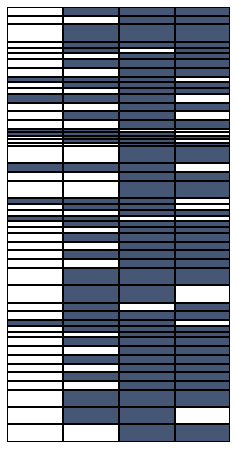

In [447]:
fig2, ax_hm = plt.subplots(figsize=(4, 8), ncols=1, nrows=topN_now, gridspec_kw={"hspace": 0}, sharex=True)

from matplotlib.colors import LinearSegmentedColormap
#cmp = LinearSegmentedColormap.from_list("custom_cmp", ["white", "#465775"], N=256)
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["white", "#465775"], N=256)

for idx, (k,v) in enumerate(goi_data.items()):
    s = sns.heatmap(v, ax=ax_hm[idx], cmap=cmp, cbar=False, yticklabels=False, xticklabels=False, linecolor='black', linewidth=0.1)

fig2.savefig(f"/home/carlos/oldies/manuscripts/review/reworked_figs/heatmap_topN.png", dpi=300, facecolor="white", edgecolor='none')
fig2.savefig(f"/home/carlos/oldies/manuscripts/review/reworked_figs/heatmap_topN.svg", facecolor="white", edgecolor='none')